# Project - Rusty Bargain 

## Table of Contents

* [Project description](#Project_description)
* [Data description](#Data_description)
* [Import Libraries and Preprocess the Data](#Libraries)
* [Prepare the data](#Prepare)
    * [EDA](#EDA)
    * [Prepare for ML](#Prepare_for_ML)
* [Train different models with various hyperparameters](#train)
    * [Split the data](#split)
    * [Random Forest Regressor](#RandomForestRegressor)
    * [LightGBM regressor](#LightGBM)
    * [Catboost regressor](#Catboost)
    * [XGBoost regressor](#XGBoost)
* [Analyze the speed and quality of the models](#quality)
* [Sanity check](#sanity)
* [Conclusion](#conclusion)

## Project description <a class="anchor" id="Project_description"></a>

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. 
Using different ML regression models: Random Forest Regressor, XGBoost regressor, LightGBM regressor, Catboost regressor based on historical data: technical specifications, trim versions, and prices. The model to determine the value.

Rusty Bargain is interested in:
* the quality of the prediction
* the speed of the prediction
* the time required for training


## Data description <a class="anchor" id="Data_description"></a>


**Features:**
* DateCrawled — date profile was downloaded from the database
* VehicleType — vehicle body type
* RegistrationYear — vehicle registration year
* Gearbox — gearbox type
* Power — power (hp)
* Model — vehicle model
* Mileage — mileage (measured in km due to dataset's regional specifics)
* RegistrationMonth — vehicle registration month
* FuelType — fuel type
* Brand — vehicle brand
* NotRepaired — vehicle repaired or not
* DateCreated — date of profile creation
* NumberOfPictures — number of vehicle pictures
* PostalCode — postal code of profile owner (user)
* LastSeen — date of the last activity of the user

**Target:**
* Price — price (Euro)

## Import Libraries and Preprocess the Data <a class="anchor" id="Libraries"></a>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState
from pprint import pprint
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.preprocessing import StandardScaler
import time
from statistics import mean
import catboost as cb
from sklearn.preprocessing import OrdinalEncoder
from catboost import Pool, cv
import math
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

## Import and Prepare the data<a class="anchor" id="Prepare"></a>

In [2]:
#Import the data
try:
    data = pd.read_csv('car_data.csv')
    
except:
    print("Something went wrong when opening the file")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
columns = list(data.columns)
a = (map(lambda x: x.lower(), columns))
b = list(a)
data.columns = b
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   mileage            354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
print("duplicates number: {}".format(data.duplicated().sum()))

duplicates number: 262


<div style="border:solid black 2px; padding: 20px"> <b>Note:</b><br>
262 duplication is a low number and will be deleted 

In [6]:
#deletion of duplicates
data = data.drop_duplicates()
print("duplicates number: {}".format(data.duplicated().sum()))

duplicates number: 0


In [7]:
print(f"Rows with NaNs in the dataset: {data.isnull().any(axis=1).sum()}")


Rows with NaNs in the dataset: 108540


In [8]:
#finding missing values
report = data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False).style.background_gradient('coolwarm')

,missing_values,% of total
notrepaired,71145,0.200000
vehicletype,37484,0.110000
fueltype,32889,0.090000
gearbox,19830,0.060000
model,19701,0.060000
datecrawled,0,0.000000
price,0,0.000000
registrationyear,0,0.000000
power,0,0.000000
mileage,0,0.000000


<div style="border:solid black 2px; padding: 20px"> <b>Note on missing values:</b><br>
Because there are so many categorical NaN values in the DataFrames, we cannot simply drop them or fill them using different methods. Hence, the missing values will be filled with the value 'unknown'. 

In [9]:
data = data.fillna('unknown')

In [10]:
report = data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False).style.background_gradient('coolwarm')

,missing_values,% of total
datecrawled,0,0.000000
price,0,0.000000
vehicletype,0,0.000000
registrationyear,0,0.000000
gearbox,0,0.000000
power,0,0.000000
model,0,0.000000
mileage,0,0.000000
registrationmonth,0,0.000000
fueltype,0,0.000000


### EDA<a class="anchor" id="EDA"></a>

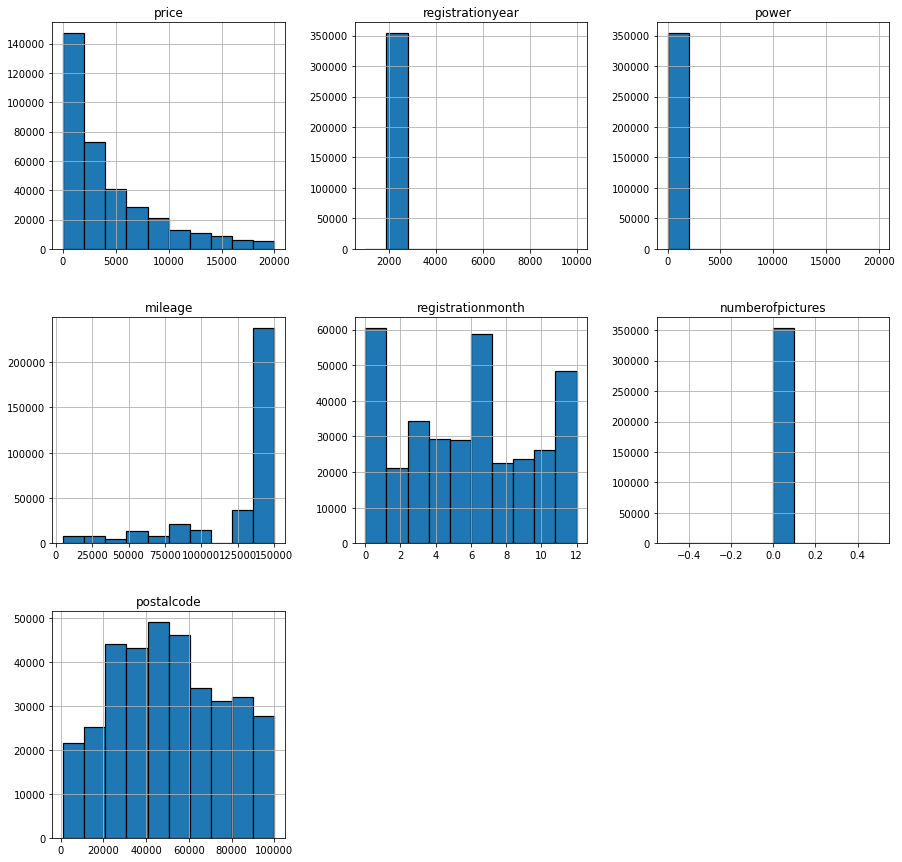

In [11]:
data.hist(edgecolor='black', linewidth=1.2, figsize=(15,15));

<div style="border:solid black 2px; padding: 20px"> <b>Note on outliers:</b><br>
there are outliers in none catgorical features and the target that can affect the prediction and need to  be removed:
    
    * price - target
    * power
    * registrationmonth
    * registrationyear

In [12]:
#price bigger than 100 
data = data.query('price >= 100')

In [13]:
#hp can't be 0 or more than 2000
#https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output
data = data.query('2000 > power > 0')

In [14]:

#registrationmonth can't be 0 
data = data.query('registrationmonth > 0')

In [15]:

#registrationyear can't be less than 1900 or more than 2022 
data = data.query('2022 >=registrationyear >= 1900')

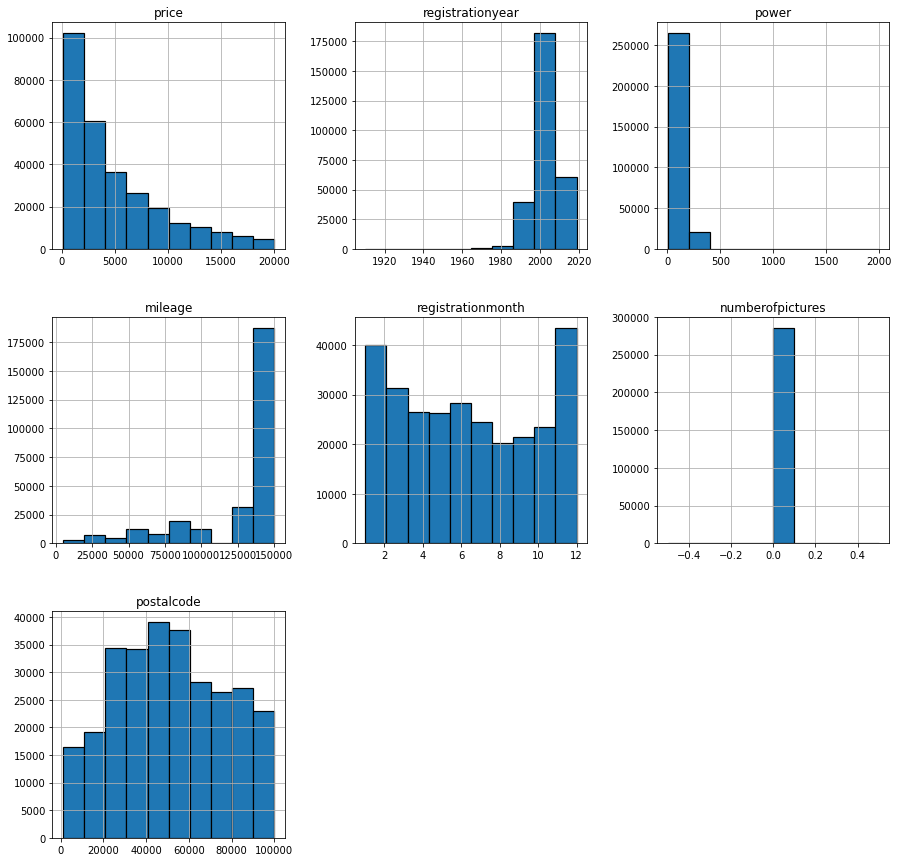

In [16]:
data.hist(edgecolor='black', linewidth=1.2, figsize=(15,15));

### Prepare for ML <a class="anchor" id="Prepare_for_ML"></a>

The features will convert in these ways: 
* OrdinalEncoder - vehicletype, fueltype, model,brand
* One-Hot Encoding  - notrepaired,gearbox
* Date features to drop - 'datecrawled','lastseen','datecreated' 

In [17]:
# Date Features to drop
data_o = data.drop(['datecrawled','lastseen','datecreated',],axis=1)


In [18]:
#One-Hot Encoding
data_ohe = pd.get_dummies(data_o, columns=['notrepaired', 'gearbox'])

In [19]:
#droping features to avoid dummy trap
data_ohe = data_ohe.drop(['notrepaired_unknown','notrepaired_no','gearbox_manual','gearbox_unknown'],axis=1)

In [20]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285859 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              285859 non-null  int64 
 1   vehicletype        285859 non-null  object
 2   registrationyear   285859 non-null  int64 
 3   power              285859 non-null  int64 
 4   model              285859 non-null  object
 5   mileage            285859 non-null  int64 
 6   registrationmonth  285859 non-null  int64 
 7   fueltype           285859 non-null  object
 8   brand              285859 non-null  object
 9   numberofpictures   285859 non-null  int64 
 10  postalcode         285859 non-null  int64 
 11  notrepaired_yes    285859 non-null  uint8 
 12  gearbox_auto       285859 non-null  uint8 
dtypes: int64(7), object(4), uint8(2)
memory usage: 26.7+ MB


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285859 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        285859 non-null  object
 1   price              285859 non-null  int64 
 2   vehicletype        285859 non-null  object
 3   registrationyear   285859 non-null  int64 
 4   gearbox            285859 non-null  object
 5   power              285859 non-null  int64 
 6   model              285859 non-null  object
 7   mileage            285859 non-null  int64 
 8   registrationmonth  285859 non-null  int64 
 9   fueltype           285859 non-null  object
 10  brand              285859 non-null  object
 11  notrepaired        285859 non-null  object
 12  datecreated        285859 non-null  object
 13  numberofpictures   285859 non-null  int64 
 14  postalcode         285859 non-null  int64 
 15  lastseen           285859 non-null  object
dtypes: int64(7), object(

In [24]:
#Ordinal Encoder
enc = OrdinalEncoder()

In [25]:
enc.fit(data_ohe[["vehicletype", "fueltype", "model","brand"]])

OrdinalEncoder()

In [26]:
data_ohe.head()

,price,vehicletype,registrationyear,power,model,mileage,registrationmonth,fueltype,brand,numberofpictures,postalcode,notrepaired_yes,gearbox_auto
1,18300,coupe,2011,190,unknown,125000,5,gasoline,audi,0,66954,1,0
2,9800,suv,2004,163,grand,125000,8,gasoline,jeep,0,90480,0,1
3,1500,small,2001,75,golf,150000,6,petrol,volkswagen,0,91074,0,0
4,3600,small,2008,69,fabia,90000,7,gasoline,skoda,0,60437,0,0
5,650,sedan,1995,102,3er,150000,10,petrol,bmw,0,33775,1,0


In [27]:
#convert the features for Ordinal Encoder
data_ohe[["vehicletype", "fueltype", "model","brand"]] = enc.transform(data_ohe[["vehicletype", "fueltype", "model","brand"]])


In [28]:
data_ohe.head()

,price,vehicletype,registrationyear,power,model,mileage,registrationmonth,fueltype,brand,numberofpictures,postalcode,notrepaired_yes,gearbox_auto
1,18300,2.0,2011,190,227.0,125000,5,2.0,1.0,0,66954,1,0
2,9800,6.0,2004,163,117.0,125000,8,2.0,14.0,0,90480,0,1
3,1500,5.0,2001,75,116.0,150000,6,6.0,38.0,0,91074,0,0
4,3600,5.0,2008,69,101.0,90000,7,2.0,31.0,0,60437,0,0
5,650,4.0,1995,102,11.0,150000,10,6.0,2.0,0,33775,1,0


In [29]:
#change data type to int64
data_ohe['vehicletype'] = data_ohe['vehicletype'].astype('int64')
data_ohe['model'] = data_ohe['model'].astype('int64')
data_ohe['fueltype'] = data_ohe['fueltype'].astype('int64')
data_ohe['brand'] = data_ohe['brand'].astype('int64')


In [30]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285859 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   price              285859 non-null  int64
 1   vehicletype        285859 non-null  int64
 2   registrationyear   285859 non-null  int64
 3   power              285859 non-null  int64
 4   model              285859 non-null  int64
 5   mileage            285859 non-null  int64
 6   registrationmonth  285859 non-null  int64
 7   fueltype           285859 non-null  int64
 8   brand              285859 non-null  int64
 9   numberofpictures   285859 non-null  int64
 10  postalcode         285859 non-null  int64
 11  notrepaired_yes    285859 non-null  uint8
 12  gearbox_auto       285859 non-null  uint8
dtypes: int64(11), uint8(2)
memory usage: 26.7 MB


In [31]:
report = data_ohe.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / data_ohe.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False).style.background_gradient('coolwarm')

,missing_values,% of total
price,0,0.000000
vehicletype,0,0.000000
registrationyear,0,0.000000
power,0,0.000000
model,0,0.000000
mileage,0,0.000000
registrationmonth,0,0.000000
fueltype,0,0.000000
brand,0,0.000000
numberofpictures,0,0.000000


<div style="border:solid black 2px; padding: 20px"> <b>Note on data preparation for ML:</b><br>
After filling the missing values in the categorical features, and removing outliers from the noncategorical features, the categorical features were converted to numerical values to use for machine learning models. 
although OrdinalEncoder might not be optimal, there were too many values in the features: "vehicletype", "fueltype", "model", "brand", that converting these features with ohe would be cause the model to use too much CPU and will take way too long to compute the answer, which is very important for an app such as this with users that will want to have the answer fast. 


## Train different models with various hyperparameters<a class="anchor" id="train"></a>

In this section, 4 different machine learning models are trained to achieve the best prediction and compering these models using the RMSE metric to evaluate the models.
The models are Regression models beacuse they are used to predict the continuous values such as price.

the models:
* Random forrest Regressor
* LightGBM Regressor
* CatBoost Regressor
*  XGBoost Regressor

### Split the data <a class="anchor" id="split"></a>

In [32]:
#splitting for training, validation, and test sets
train_df1, test_df = train_test_split(data_ohe, test_size=0.2, random_state=12345)
train_df, valid_df = train_test_split(train_df1, test_size=0.25, random_state=12345)

In [33]:
#features without a target
features_train = train_df.drop('price',axis=1)
features_valid = valid_df.drop('price',axis=1)
features_test = test_df.drop('price',axis=1)

In [34]:
print("features_train:",features_train.shape)
print("features_train:",features_valid.shape)
print("features_test:",features_test.shape)

features_train: (171515, 12)
features_train: (57172, 12)
features_test: (57172, 12)


In [35]:
#target 
target_train = train_df['price']
target_valid = valid_df['price']
target_test = test_df['price']

In [36]:
print("target_train:",target_train.shape)
print("target_valid:",target_valid.shape)
print("target_test:",target_test.shape)

target_train: (171515,)
target_valid: (57172,)
target_test: (57172,)


### Random Forest Regressor<a class="anchor" id="RandomForestRegressor"></a>

In [37]:

#seting an empthy data frame
rf_parameters = pd.DataFrame()
#lists for dataframe
rf_score_train = []
rf_score_valid = []
estimators = []
depths = []
#iteration through different parameters to find the best RandomForestRegressor parameters
for n in range(10,50, 10):
    for depth in range(10, 50 ,10):
        model=RandomForestRegressor(max_depth=depth, n_estimators= n, random_state=12345)
        model.fit(features_train, target_train)
        y_train_pred = model.predict(features_train)
        y_val_pred = model.predict(features_valid)
        train_error_RMSE = (mean_squared_error(target_train, y_train_pred))**0.5
        validation_RMSE = (mean_squared_error(target_valid, y_val_pred))**0.5

        rf_score_train.append(train_error_RMSE)
        rf_score_valid.append(validation_RMSE)
        estimators.append(n)
        depths.append(depth)
rf_parameters['n_estimators'] = estimators
rf_parameters['depths']=depths
rf_parameters['RMSE_score_train']=rf_score_train
rf_parameters['RMSE_score_valid']=rf_score_valid


In [38]:
rf_parameters[rf_parameters['RMSE_score_valid'] == rf_parameters.RMSE_score_valid.min()]

,n_estimators,depths,RMSE_score_train,RMSE_score_valid
15,40,40,621.689535,1597.148813


### LightGBM regressor <a class="anchor" id="LightGBM"></a>

In [39]:

#seting an empthy data frame
lgm_parameters = pd.DataFrame()
#lists for dataframe
lgm_score_train = []
lgm_score_valid = []
estimators = []
depths = []
#iteration through different parameters to find the best RandomForestRegressor parameters
for n in range(20,200, 10):
    for depth in range(10, 200 ,10):
        model=lgb.LGBMRegressor(boosting_type='gbdt', max_depth=- depth, n_estimators=n)
        model.fit(features_train, target_train)
        y_train_pred = model.predict(features_train)
        y_val_pred = model.predict(features_valid)
        train_error_RMSE = (mean_squared_error(target_train, y_train_pred))**0.5
        validation_RMSE = (mean_squared_error(target_valid, y_val_pred))**0.5
        
        lgm_score_train.append(train_error_RMSE)
        lgm_score_valid.append(validation_RMSE)
        estimators.append(n)
        depths.append(depth)
lgm_parameters['n_estimators'] = estimators
lgm_parameters['depths']=depths
lgm_parameters['RMSE_score_train']=lgm_score_train
lgm_parameters['RMSE_score_valid']=lgm_score_valid

In [40]:
lgm_parameters[lgm_parameters['RMSE_score_valid'] == lgm_parameters.RMSE_score_valid.min()]

,n_estimators,depths,RMSE_score_train,RMSE_score_valid
323,190,10,1598.585261,1655.763308
324,190,20,1598.585261,1655.763308
325,190,30,1598.585261,1655.763308
326,190,40,1598.585261,1655.763308
327,190,50,1598.585261,1655.763308
328,190,60,1598.585261,1655.763308
329,190,70,1598.585261,1655.763308
330,190,80,1598.585261,1655.763308
331,190,90,1598.585261,1655.763308
332,190,100,1598.585261,1655.763308


### Catboost regressor<a class="anchor" id="Catboost"></a>

In [41]:
cat_features = ['vehicletype', 'model', 'fueltype', 'brand', 'notrepaired_yes', 'gearbox_auto']
#seting an empthy data frame
Catboost_parameters = pd.DataFrame()
#lists for dataframe
cb_score_train = []
cb_score_valid = []
estimators = []
depths = []
#iteration through different parameters to find the best RandomForestRegressor parameters
for n in range(50,250, 50):
    for depth in range(0, 20 ,4):
        model=cb.CatBoostRegressor(max_depth=depth, iterations=n,cat_features=cat_features,loss_function= "RMSE",verbose= 10)
        model.fit(features_train, target_train)
        y_train_pred = model.predict(features_train)
        y_val_pred = model.predict(features_valid)
        train_error_RMSE = (mean_squared_error(target_train, y_train_pred))**0.5
        validation_RMSE = (mean_squared_error(target_valid, y_val_pred))**0.5
        
        cb_score_train.append(train_error_RMSE)
        cb_score_valid.append(validation_RMSE)
        estimators.append(n)
        depths.append(depth)
Catboost_parameters['iterations'] = estimators
Catboost_parameters['depths']=depths
Catboost_parameters['RMSE_score_train']=cb_score_train
Catboost_parameters['RMSE_score_valid']=cb_score_valid

Learning rate set to 0.5
0:	learn: 4626.8653908	total: 166ms	remaining: 8.13s
10:	learn: 4626.8653908	total: 221ms	remaining: 784ms
20:	learn: 4626.8653908	total: 272ms	remaining: 376ms
30:	learn: 4626.8653908	total: 322ms	remaining: 198ms
40:	learn: 4626.8653908	total: 373ms	remaining: 81.8ms
49:	learn: 4626.8653908	total: 430ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3452.3584164	total: 33.3ms	remaining: 1.63s
10:	learn: 2059.3038437	total: 509ms	remaining: 1.8s
20:	learn: 1940.7708425	total: 857ms	remaining: 1.18s
30:	learn: 1884.9458249	total: 1.28s	remaining: 784ms
40:	learn: 1842.8370335	total: 1.58s	remaining: 348ms
49:	learn: 1816.9635815	total: 1.83s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3208.2603380	total: 48.9ms	remaining: 2.39s
10:	learn: 1836.7254128	total: 522ms	remaining: 1.85s
20:	learn: 1746.5052659	total: 976ms	remaining: 1.35s
30:	learn: 1695.4719718	total: 1.45s	remaining: 890ms
40:	learn: 1657.9623569	total: 1.95s	remaining: 429ms
49:	learn: 1

In [42]:
Catboost_parameters[Catboost_parameters['RMSE_score_valid'] == Catboost_parameters.RMSE_score_valid.min()]

,iterations,depths,RMSE_score_train,RMSE_score_valid
18,200,12,1215.300242,1578.696592


### XGBoost regressor <a class="anchor" id="XGBoost"></a>

In [43]:
#model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

#seting an empthy data frame
XGBoost_parameters = pd.DataFrame()
#lists for dataframe
xgb_score_train = []
xgb_score_valid = []
estimators = []
depths = []
#eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.

#iteration through different parameters to find the best RandomForestRegressor parameters
for n in range(10,100, 10):
    for depth in range(5, 20 ,5):
        model=xgb.XGBRegressor(n_estimators=n, max_depth=depth)
        model.fit(features_train, target_train)
        y_train_pred = model.predict(features_train)
        y_val_pred = model.predict(features_valid)
        train_error_RMSE = (mean_squared_error(target_train, y_train_pred))**0.5
        validation_RMSE = (mean_squared_error(target_valid, y_val_pred))**0.5

        xgb_score_train.append(train_error_RMSE)
        xgb_score_valid.append(validation_RMSE)
        estimators.append(n)
        depths.append(depth)
        
XGBoost_parameters['iterations'] = estimators
XGBoost_parameters['depths']=depths
XGBoost_parameters['RMSE_score_train']=xgb_score_train
XGBoost_parameters['RMSE_score_valid']=xgb_score_valid


In [44]:
XGBoost_parameters[XGBoost_parameters['RMSE_score_valid'] == XGBoost_parameters.RMSE_score_valid.min()]

,iterations,depths,RMSE_score_train,RMSE_score_valid
25,90,10,1056.050546,1573.085989


## Analyze the speed and quality of the models <a class="anchor" id="quality"></a>

In [45]:
%%time

#Random Forest Regressor

rf_model = RandomForestRegressor(max_depth=20, n_estimators= 40, random_state=12345)
rf_model.fit(features_train, target_train)
rf_y_test_pred = model.predict(features_test)
rf_test_RMSE = (mean_squared_error(target_test, rf_y_test_pred))**0.5
print('The RMSE for Random Forest Regressor is:',round(rf_test_RMSE,2))



The RMSE for Random Forest Regressor is: 1605.34
Wall time: 14.9 s


In [46]:
%%time

#XGBRegressor
xgb_model = xgb.XGBRegressor(n_estimators=90, max_depth=10)
xgb_model.fit(features_train, target_train)
xgb_y_val_pred = xgb_model.predict(features_test)
xgb_test_RMSE = (mean_squared_error(target_test, xgb_y_val_pred))**0.5
print('The RMSE for XGBRegressor is:',round(xgb_test_RMSE,2))

The RMSE for XGBRegressor is: 1574.87
Wall time: 4.1 s


In [47]:
%%time

#LightGBM Regressor
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', max_depth=- 10, n_estimators=190)
lgb_model.fit(features_train, target_train)
lgb_y_val_pred = lgb_model.predict(features_test)
lgb_test_RMSE = (mean_squared_error(target_test, lgb_y_val_pred))**0.5
print('The RMSE for LightGBM Regressor is:',round(lgb_test_RMSE,2))

The RMSE for LightGBM Regressor is: 1643.13
Wall time: 432 ms


In [49]:
%%time

#Catboost Regressor
cat_features = ['vehicletype', 'model', 'fueltype', 'brand', 'notrepaired_yes', 'gearbox_auto']
cb_model = cb.CatBoostRegressor(max_depth=12, iterations=200,cat_features=cat_features,loss_function= "RMSE",verbose= 10)
cb_model.fit(features_train, target_train)
cb_y_val_pred = cb_model.predict(features_test)
cb_test_RMSE = (mean_squared_error(target_test, cb_y_val_pred))**0.5
print('The RMSE for Catboost Regressor is:',round(cb_test_RMSE,2))

Learning rate set to 0.341556
0:	learn: 3504.2966920	total: 155ms	remaining: 30.8s
10:	learn: 1719.2372166	total: 1.64s	remaining: 28.2s
20:	learn: 1617.2619894	total: 3.11s	remaining: 26.5s
30:	learn: 1558.9578228	total: 4.71s	remaining: 25.7s
40:	learn: 1502.9212348	total: 6.24s	remaining: 24.2s
50:	learn: 1473.3350125	total: 7.66s	remaining: 22.4s
60:	learn: 1430.4269321	total: 9.21s	remaining: 21s
70:	learn: 1404.1977101	total: 10.7s	remaining: 19.5s
80:	learn: 1382.7018484	total: 12.3s	remaining: 18.1s
90:	learn: 1351.9463621	total: 14s	remaining: 16.8s
100:	learn: 1329.0350254	total: 15.6s	remaining: 15.3s
110:	learn: 1304.8899527	total: 17.1s	remaining: 13.7s
120:	learn: 1288.2791685	total: 18.6s	remaining: 12.2s
130:	learn: 1269.8714872	total: 20.1s	remaining: 10.6s
140:	learn: 1249.7767438	total: 21.6s	remaining: 9.04s
150:	learn: 1233.7416185	total: 23.1s	remaining: 7.5s
160:	learn: 1220.8538960	total: 24.7s	remaining: 5.99s
170:	learn: 1205.5419750	total: 26.5s	remaining: 4.

<div style="border:solid black 2px; padding: 20px"> <b>Note on Analyze the speed and quality of the models:</b><br>
After training the models, the model with the highest precision is the one with the lowest RMES value which is the XGBRegressor with ~1573. the model with the shortest time is the LightGBM Regressor.

## Sanity check<a class="anchor" id="sanity"></a>

In [50]:
%%time
reg = LinearRegression().fit(features_train, target_train)
y_test_pred = model.predict(features_test)
rmes_test_error = (mean_squared_error(target_test, y_test_pred))**0.5
print('LinearRegression RMES values:',rmes_test_error)


LinearRegression RMES values: 1605.3399451150963
Wall time: 116 ms


<div style="border:solid black 2px; padding: 20px"> <b>Note on Sanity check:</b><br>
 In this section we 'trained' our sanity 'model' -LinearRegression using the training dataset. As it turns out, the sanity 'model's' score is slightly higher than our best model's score. Though the difference isn't very much, it does show that XGBRegressor is a step in the right direction.

## Conclusion<a class="anchor" id="conclusion"></a>


In this project, I've shown how to predict the price of a car given a dataset using different models with different parameters tuning. the best model is the XGBRegressor, which was the most precise and with a relatively short time of ~5 seconds. 
However, although the model was the best of all 4, the RMES is still high, around 1500$ where some prices are 100$ meaning a big margin of error. This outcome may be a result of the data wrangling or the converting of the categorical data, in specific the car 'model' feature.
In addition, the models did not go through cross-validation during training, which might help the precision. 